<font size=6>Clustering of the Pacific Decadal Oscillation w/ Variational Inference</font>

This notebook will be used to cluster data from NOAA about the pacific decadal oscillation.

<font size=5> Data source </font>

https://www.ncei.noaa.gov/access/monitoring/pdo/

The Pacific Decadal Oscillation (PDO) is often described as a long-lived El Niño-like pattern of Pacific climate variability (Zhang et al. 1997). As seen with the better-known El Niño/Southern Oscillation (ENSO), extremes in the PDO pattern are marked by widespread variations in the Pacific Basin and the North American climate. In parallel with the ENSO phenomenon, the extreme phases of the PDO have been classified as being either warm or cool, as defined by ocean temperature anomalies in the northeast and tropical Pacific Ocean. When SSTs are anomalously cool in the interior North Pacific and warm along the Pacific Coast, and when sea level pressures are below average over the North Pacific, the PDO has a positive value. When the climate anomaly patterns are reversed, with warm SST anomalies in the interior and cool SST anomalies along the North American coast, or above average sea level pressures over the North Pacific, the PDO has a negative value (Courtesy of Mantua, 1999).

<font size=5>Add dependencies</font>

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

import sklearn 
import sklearn.mixture as mix 

<font size=5>Cluster the data</font>

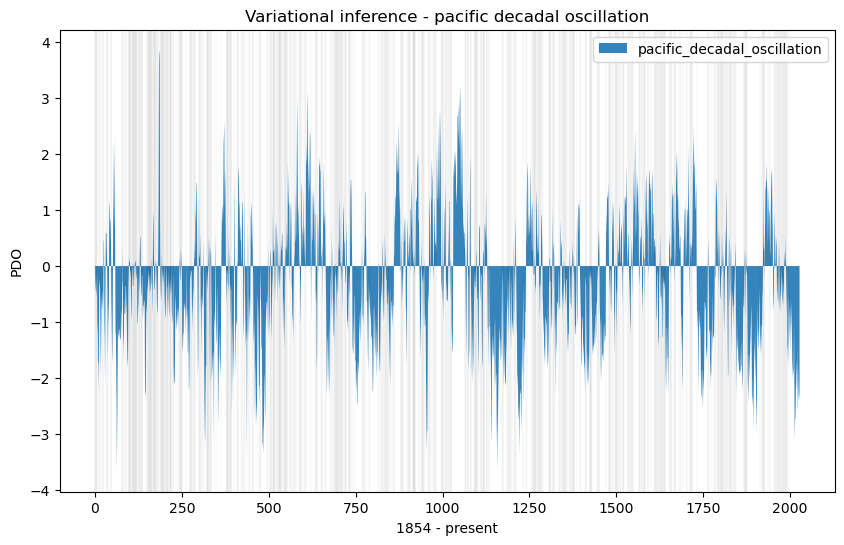

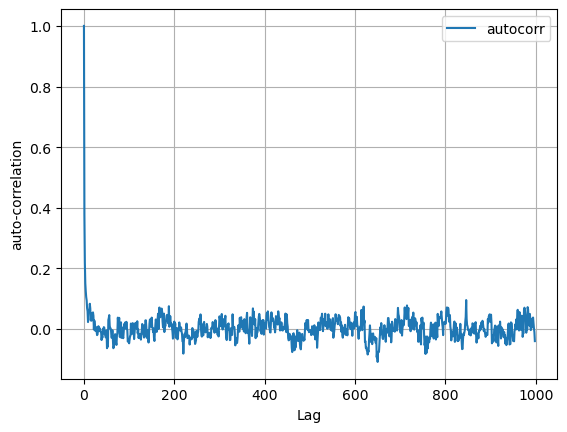

[[0.5899654  0.02941176 0.14186851 0.23875433 0.        ]
 [0.02636917 0.68762677 0.         0.25760649 0.02839757]
 [0.29277567 0.         0.65019011 0.05703422 0.        ]
 [0.21907601 0.18330849 0.01490313 0.58271237 0.        ]
 [0.         0.60869565 0.         0.         0.39130435]]


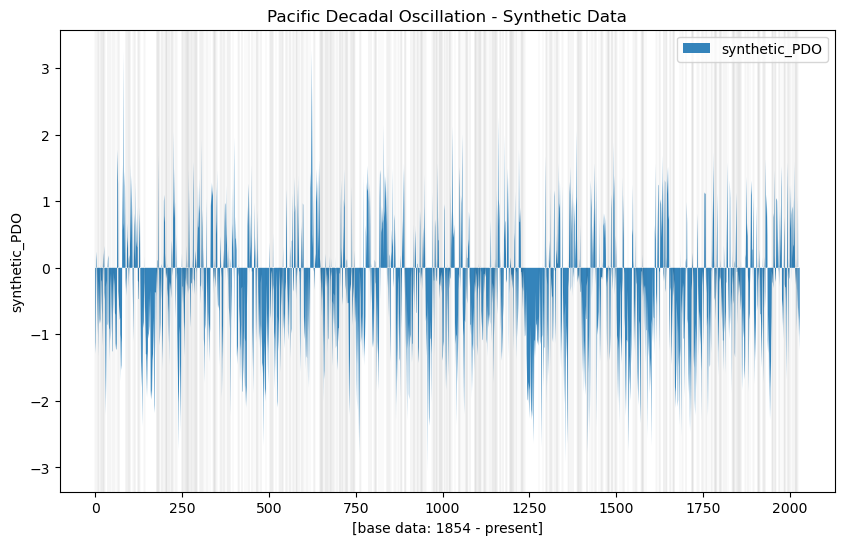

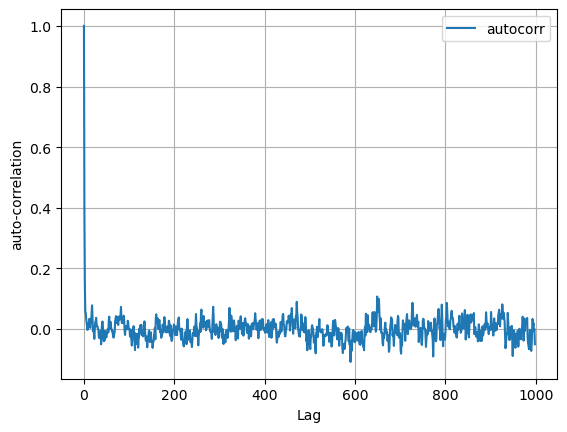

In [6]:
# Read PDO data
pdo = pd.read_csv('.././data/PDO.dat')
pdo_array = []

# Format the data into a single array for each year/month in sequence 
for val in pdo['Year  Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec']:
    pdo_array.append([ float(v) for v in val.split()[1:] ])

# Reshape  
pdo_array = np.array(pdo_array).flatten().reshape(-1, 1)
num_components=5

# Fit Variational inference model 
dpgmm_model = mix.BayesianGaussianMixture(n_components=num_components, 
                                          weight_concentration_prior_type='dirichlet_process',
                                          n_init=2, 
                                          max_iter=50)
states = dpgmm_model.fit_predict(pdo_array)

# Plot results 
fig,ax = plt.subplots(figsize=(10, 6
                              ))
ax.stackplot(range(len(pdo_array)), pdo_array.flatten(), alpha=0.9)

# Include states 
state_counts = np.zeros(num_components)
for M in states:
  state_counts[M] += 1 

for M in range(len(states)): 
  if states[M] == np.argmax(state_counts):
    ax.axvline(M, color='black', alpha=0.02)
    
plt.title('Variational inference - pacific decadal oscillation')
plt.ylabel('PDO')
plt.xlabel('1854 - present')
plt.legend(labels=['pacific_decadal_oscillation'])
plt.show()

# Auto-correlation decay function
decay_func = lambda S, _range: [S.autocorr(lag=Lag) for Lag in _range]

# Filter out all but the final state, and look at the auto-correlation of that Markov state alone 
statesdf=pd.DataFrame()
pdo_array=pdo_array.flatten()
statesdf['bayes_filter']=[ 1 if states[M] == np.argmax(state_counts) else 0 for M in range(0, len(states)) ]
statesdf=statesdf.dropna()

sns.lineplot(data=decay_func(statesdf['bayes_filter'], range(0, 999)), label='autocorr')
plt.xlabel('Lag')
plt.ylabel('auto-correlation')
plt.grid(True)
plt.show()

num_states = np.unique(states).size

# Initialize the transition matrix with zeros
transition_matrix = np.zeros((num_states, num_states))

# Loop through the array of states and update the transition matrix
for i in range(len(states)):
    current_state = states[i]
    previous_state = states[i-1]
    transition_matrix[previous_state, current_state] += 1

# Normalize the transition matrix
transition_matrix = transition_matrix / np.sum(transition_matrix, axis=1, keepdims=True)
transition_matrix[np.isnan(transition_matrix)] = None
print(transition_matrix) 

# Orig
y = [] 
sample = []

# Sample one at a time using transition matrix 
current_state = np.argmax(state_counts) 

# 
sample.append(np.random.normal(loc=dpgmm_model.means_[current_state][0], scale=dpgmm_model.covariances_[current_state][0])[0])
y.append(current_state)
    
for i in range(len(pdo_array)):
    current_state = np.random.choice(num_states, p=transition_matrix[current_state])
    current_mean = dpgmm_model.means_[current_state][0]
    current_var = dpgmm_model.covariances_[current_state][0]
    s = np.random.normal(loc=current_mean, scale=current_var)
    sample.append(s[0])
    y.append(current_state)

y_counts = np.zeros(num_components)
for M in y:
  y_counts[M] += 1 

fig,ax = plt.subplots(figsize=(10, 6
                              ))
ax.stackplot(range(len(sample)), sample, alpha=0.9)
plt.legend(labels=['synthetic_PDO'])
plt.title('Pacific Decadal Oscillation - Synthetic Data')
plt.ylabel('synthetic_PDO')
plt.xlabel('[base data: 1854 - present]')

for M in range(len(y)): 
  if y[M] == np.argmax(y_counts):
    ax.axvline(M, color='black', alpha=0.02)
plt.show()

ydf=pd.DataFrame()
ydf['bayes_filter']=[ 1 if y[M] == np.argmax(y_counts) else 0 for M in range(0, len(y)) ]
ydf=ydf.dropna()

sns.lineplot(data=decay_func(ydf['bayes_filter'], range(0, 999)), label='autocorr')
plt.xlabel('Lag')
plt.ylabel('auto-correlation')
plt.grid(True)
plt.show()

Note: you may need to restart the kernel to use updated packages.


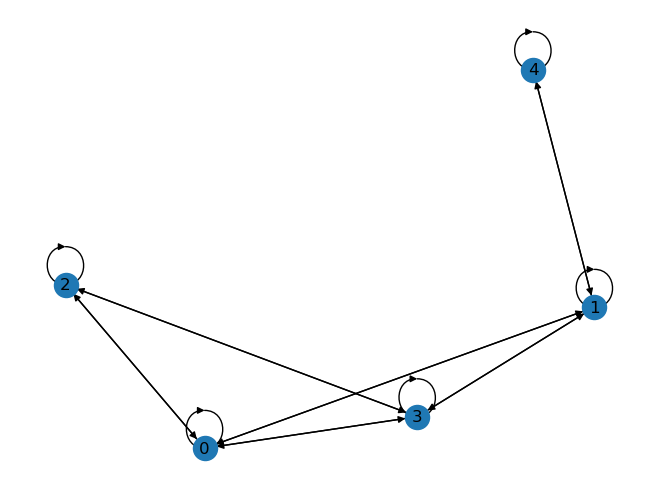

In [7]:
%pip install networkx 
import networkx as nx
import matplotlib.pyplot as plt 

G = nx.DiGraph(transition_matrix)
nx.draw(G, with_labels=True)
plt.show()